### Final EWMACD Method

In [1]:
# globals (dev)
FOLDER_MODULES = r'C:\Users\Lewis\Documents\GitHub\tenement-tools\modules'  
FOLDER_SHARED = r'C:\Users\Lewis\Documents\GitHub\tenement-tools\shared'
GRP_LYR_FILE = r"C:\Users\Lewis\Documents\GitHub\tenement-tools\arc\lyr\group_template.lyrx"

# set gdal global environ
import os
os.environ['GDAL_DISABLE_READDIR_ON_OPEN'] = 'EMPTY_DIR'
os.environ['CPL_VSIL_CURL_ALLOWED_EXTENSIONS '] = 'tif'
os.environ['VSI_CACHE '] = 'TRUE'
os.environ['GDAL_HTTP_MULTIRANGE '] = 'YES'
os.environ['GDAL_HTTP_MERGE_CONSECUTIVE_RANGES '] = 'YES'

# also set rasterio env variables
rasterio_env = {
    'GDAL_DISABLE_READDIR_ON_OPEN': 'EMPTY_DIR',
    'CPL_VSIL_CURL_ALLOWED_EXTENSIONS':'tif',
    'VSI_CACHE': True,
    'GDAL_HTTP_MULTIRANGE': 'YES',
    'GDAL_HTTP_MERGE_CONSECUTIVE_RANGES': 'YES'
}

# safe imports
import sys                      # arcgis comes with these
import shutil                   # arcgis comes with these
import datetime                 # arcgis comes with these
import numpy as np              # arcgis comes with these
import arcpy                    # arcgis comes with these
import tempfile                 # arcgis comes with these
from datetime import datetime   # arcgis comes with these

# risky imports (not native to arcgis)
try:
    import xarray as xr
    import dask
    import rasterio
    import pystac_client
    import osr
    import json
    from odc import stac
    from osgeo import gdal
    from osgeo import ogr
    from osgeo import osr
except:
    arcpy.AddError('Python libraries xarray, dask, rasterio, pystac, or odc not installed.')
    raise # return

# import tools
try:
    # shared folder
    sys.path.append(FOLDER_SHARED)
    import arc, satfetcher, tools

    # module folder
    sys.path.append(FOLDER_MODULES)
    import nrt, cog_odc, cog
except:
    arcpy.AddError('Could not find tenement tools python scripts (modules, shared).')
    raise
    
# disable future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=dask.array.core.PerformanceWarning)
    
# grab parameter values 
in_feat = r"C:\Users\Lewis\Desktop\nrt_projects\ophthalmia\monitoring_areas.gdb\monitoring_areas"
in_ongoing = False
in_time_interval = 24
#in_email_from = parameters[3].value                # email from 
#in_smtp_server = parameters[4].value               # email smtp server 
#in_smtp_port = parameters[5].value                 # email smtp port 
#in_smtp_username = parameters[6].value             # email smtp username 
#in_smtp_password = parameters[7].value             # email smtp password 


# # # # #
# notify user and set up progress bar
#arcpy.AddMessage('Beginning NRT Monitoring of areas.')
#arcpy.SetProgressor(type='step', 
                    #message='Preparing parameters...',
                    #min_range=0, max_range=20)
        
# set up initial continous monitoring var
continue_monitoring = True

# check if time interval is > 0
#in_time_interval = in_time_interval * 60 * 60
#if in_time_interval <= 0:
    #arcpy.AddError('Time interval must be above 0 hours.')
    #raise


# # # # #
# notify and increment progress bar
#arcpy.SetProgressorLabel('Preparing parameters...')
#arcpy.SetProgressorPosition(1)

# get path to monitoring areas feature
feat_desc = arcpy.Describe(in_feat)
in_feat = os.path.join(feat_desc.path, feat_desc.name)


# # # # #
# notify and increment progress bar
#arcpy.SetProgressorLabel('Validating monitoring areas...')
#arcpy.SetProgressorPosition(2)

# validate monitoring area feature class
if not nrt.validate_monitoring_areas(in_feat):
    arcpy.AddError('Monitoring areas feature is invalid.')
    raise # return

    
# # # # #
# notify and increment progress bar
#arcpy.SetProgressorLabel('Loading monitoring area json data...')
#arcpy.SetProgressorPosition(2)
    
# prepare path to expected json file
in_path = os.path.dirname(in_feat)
in_path = os.path.splitext(in_path)[0]
in_path = os.path.dirname(in_path)
#in_data_path = os.path.join(in_path, 'data.json')
    
    
# # # # #
# notify and increment progress bar
#arcpy.SetProgressorLabel('Loading monitoring area features...')
#arcpy.SetProgressorPosition(2)

# set required fields
fields = [
    'area_id', 
    'platform', 
    's_year', 
    'e_year', 
    'index', 
    'persistence', 
    'rule_1_min_conseqs', 
    'rule_1_inc_plateaus', 
    'rule_2_min_zone', 
    'rule_3_num_zones', 
    'ruleset', 
    'alert', 
    'method',
    'alert_direction', 
    'email', 
    'ignore', 
    'color', 
    'global_id', 
    'SHAPE@'
]

# get feature count and data
try:
    #feats = arcpy.da.SearchCursor(in_feat, fields)
    feats = []
    with arcpy.da.SearchCursor(in_feat, fields) as cursor:
        for row in cursor:
            feats.append(row)
except:
    arcpy.AddError('Could not open monitoring areas feature.')
    raise # return

In [2]:
from importlib import reload
reload(nrt)

<module 'nrt' from 'C:\\Users\\Lewis\\Documents\\GitHub\\tenement-tools\\modules\\nrt.py'>

In [3]:
# todo:
# remove field rule 1 inc plateaus ... ?
# remove field rule 2 bidirection. we do this via alert dir now - DONE
# change rule 2 min stdv to min zone - DONE
# consider a 'negative remover in positive areas' and vice versa. consider during alert?... add as extra alert dirs? - DONE
# append all mon area field info to netcdf attr, check at start of run for change, delete cube if change
# check if ruleset contains rule without a value entered during area creation (fields accepts nulls) - FORCED REQUIRED!

In [4]:
'inc_any':      'Incline only (any)', 
'dec_any':      'Decline only (any)', 
'inc_pos':      'Incline only (+ zones only)', 
'dec_neg':      'Decline only (- zones only)', 
'both_any':     'Incline or Decline (any)',
'both_pos_neg': 'Incline or Decline (+/- zones only)',

SyntaxError: invalid syntax (<string>, line 1)

In [5]:
def check_xr_site_attrs(ds, feat):
    """
    For NRT monitoring, site information taken from
    the associated shapefile feature are appended to
    the attributes of the associated netcdf file. We
    rely on these attributes to ensure the user has not
    changed any parameters since last run. If they've changed
    we must reset the cube.
    """
    
    # check if dataset exists
    if ds is None:
        print('Old dataset is none. Returning none.')
        return
    elif not hasattr(ds, 's_year'):
        print('Dataset must have a start year attribute.')
        return
    
    # check start year
    if s_year is None:
        print('Start year must be provided.')
        return ds
    elif not isinstance(s_year, int):
        print('Start year must be an integer.')
        return ds
    
    # check if dataset year is same as start year value
    if ds.attrs.get('s_year') != s_year:
        print('Years dont match, returning none.')
        return
    
    return ds

In [6]:
# # # # #
# notify and set progress bar to defaukt
#arcpy.SetProgressor(type='default', 
                    #message='Iterating through monitoring areas...')

# begin monitoring process iteration
while continue_monitoring:
    for feat in feats:
        
        # # # # #
        # notify and set progress bar to defaukt
        arcpy.AddMessage('Setting up monitoring for area: {}...'.format(feat[0]))

        # !!!TODO ENSURE NO NULL VALUES IN RULES, ETC
        # check if current feat is valid
        if not nrt.validate_monitoring_area(feat):
            arcpy.AddWarning('Monitoring area is invalid, skipping.'.format(feat[0]))
            raise #continue

            
            
        # # # # #
        # notify 
        arcpy.AddMessage('Fetching new and existing satellite data for monitoring area.')     
        
        # get old dataset if exists, else return none
        in_cube_path = os.path.join(in_path, feat[-2] + '.nc')
        ds_old = nrt.safe_load_nc(in_cube_path)
        
        # check start year same as feat, if no, set old xr to none. handles old when none
        #ds_old = nrt.check_xr_start_year(ds_old, feat[2])
        # replace this with check attrs above
        
        try:
            # get satellite parameters, bbox from geometry, then lazy load
            params = nrt.get_satellite_params(platform=feat[1])
            bbox = arc.get_bbox_from_geom(in_geom=feat[-1])
            ds_new = nrt.fetch_cube_data(collections=params.get('collections'), 
                                         bands=params.get('bands'), 
                                         start_dt='1980-01-01', 
                                         #end_dt='2050-12-31',  use this when happy 
                                         end_dt='2015-12-31',
                                         bbox=bbox, 
                                         resolution=10, 
                                         ds_existing=None)

        except:
            arcpy.AddWarning('Could not obtain latest satellite data, skipping area.')
            raise # continue
            
            
            
        # # # # #
        # notify 
        arcpy.AddMessage('Reducing satellite data down to only new images.')
                
        # get latest dates from new xr, if no new (or fail), sets to none
        if ds_old is not None:
            ds_new = nrt.extract_new_xr_dates(ds_old, ds_new)
                
        # do quick check if new times were returned
        if ds_new is None:
            arcpy.AddMessage('No new satellite images found, moving to next area.')
            raise #continue
        else:
            arcpy.AddMessage('New satellite images found: {}.'.format(len(ds_new['time'])))
        
                
        
        # # # # #
        # notify 
        arcpy.AddMessage('Cleaning satellite data and calculating vegetation.')
            
        # group duplicate times if exist and rechunk
        ds_new = satfetcher.group_dupe_times(ds_new)
        
        # remove invalid pixels       
        mask_band = arc.get_name_of_mask_band(list(ds_new))
        ds_new = cog.remove_fmask_dates(ds=ds_new, 
                                        valid_class=[1, 4, 5],   # valid, water, snow
                                        max_invalid=0,           # 0% cloud
                                        mask_band=mask_band, 
                                        nodata_value=np.nan,
                                        drop_fmask=True)     

        # conform dea band names and calc vegetation index
        ds_new = satfetcher.conform_dea_ard_band_names(ds=ds_new, platform=feat[1].lower()) 
        ds_new = tools.calculate_indices(ds=ds_new, 
                                         index=feat[4].lower(), 
                                         custom_name='veg_idx', 
                                         rescale=False, 
                                         drop=True)
        
        
        
        # # # # #
        # notify 
        arcpy.AddMessage('Downloading satellite data - hold tight.')
        
        # safe load/download dataset and check output
        ds_new = nrt.safe_load_ds(ds_new)
        if ds_new is None or len(ds_new['time']) == 0 or ds_new.to_array().isnull().all():
            arcpy.AddError('Satellite download returned no data, skipping area.')  
            raise # continue

            
            
        # # # # #
        # notify 
        arcpy.AddMessage('Masking out edge pixels of monitoring area boundary.')

        try:
            # covert arcpy geom to ogr layer for masking via gjson
            gjson = arc.convert_arcpy_geom_to_gjson(arcpy_geom=feat[-1])
            ogr_geom = ogr.Open(gjson, 0)
            lyr = ogr_geom.GetLayer()

            # generate and apply mask
            mask = nrt.mask_xr_via_polygon(ds=ds_new, geom=lyr, mask_value=1)
            ds_new = ds_new.where(mask)
        except:
            arcpy.AddWarning('Could not mask edges, proceeding without mask.')
            raise #pass 
        
        
        
        # # # # #
        # notify 
        arcpy.AddMessage('Preparing old and new satellite data for analysis.')    
        
        # reduce data to temporal means, interp nans, add needed vars
        ds_new = ds_new.sortby('time').mean(['x', 'y'])
        ds_new = nrt.interp_nans(ds_new, drop_edge_nans=True)
        ds_new = nrt.add_required_vars(ds_new)

        # check if anything exists once again...
        if ds_new is None or len(ds_new['time']) == 0 or ds_new.to_array().isnull().all():
            arcpy.AddError('No satellite data exists after clean, skipping area.')  
            raise # continue
            
        # combine old xr with new xr (handles no old data)
        ds_cmb = nrt.combine_old_new_xrs(ds_old, ds_new)
        
        # remove spikes, interp nan, smooth across all time for veg
        ds_cmb['veg_clean'] = nrt.remove_spikes(ds_cmb['veg_idx'], user_factor=1, win_size=3)
        ds_cmb['veg_clean'] = nrt.interp_nans(ds_cmb['veg_clean'], drop_edge_nans=False)
        ds_cmb['veg_clean'] = nrt.smooth_signal(ds_cmb['veg_clean']) 
        
        # make a temp copy for intermediate working
        ds_tmp = ds_cmb.copy(deep=True)

        
        
        # # # # #
        # notify 
        arcpy.AddMessage('Performing change detection.')   
        
        try:  
            # remove any dates prior to training year start
            ds_tmp = ds_tmp.where(ds_tmp['time.year'] >= feat[2], drop=True)
        
            # perform change detection (append to tmp), if ewmacd fails, returns array of nans
            ds_tmp = nrt.detect_change(ds=ds_tmp,
                                       method='both',        # static
                                       var='veg_idx',        # veg_clean performs worse?
                                       train_start=feat[2], 
                                       train_end=feat[3],
                                       persistence=feat[5],
                                       add_to_ds=True)
                        
            # smooth change detection signal. if error occurs, returns original da (prob all nans)
            ds_tmp['static_clean'] = nrt.smooth_signal(ds_tmp['static_raw']) 
            ds_tmp['dynamic_clean'] = nrt.smooth_signal(ds_tmp['dynamic_raw']) 
            
            # check if anything exists once again...
            if ds_tmp['static_clean'].isnull().all() or ds_tmp['dynamic_clean'].isnull().all():
                arcpy.AddError('No change data generated, skipping area.')  
                raise # continue
        except:
            arcpy.AddError('Could not perform change detection, skipping to next area.')
            raise # continue 
                        

            
        # # # # #
        # notify 
        arcpy.AddMessage('Preparing data for rule generation.')    
        
        # transfer all old change vals to tmp, missing new. if no old, no need to transfer
        if ds_old is not None:
            data_vars = ['static_raw', 'static_clean', 'dynamic_raw', 'dynamic_clean']
            ds_tmp = nrt.transfer_xr_values(ds_to=ds_tmp,
                                            ds_from=ds_old,
                                            data_vars=data_vars)

            
        
        # # # # #
        # notify 
        arcpy.AddMessage('Generating zone values.')
        
        # build zones from smoothed static and dynamic change signals
        ds_tmp['static_zones'] = xr.apply_ufunc(nrt.build_zones, ds_tmp['static_clean'])
        ds_tmp['dynamic_zones'] = xr.apply_ufunc(nrt.build_zones, ds_tmp['dynamic_clean'])
        
        
        
        # # # # #
        # notify 
        arcpy.AddMessage('Generating rule values.')
        
        # todo: convert num_zone for r2, r3 from zone to corresponding stdv dev value
        # todo!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        
        
        
        # generate all rule 1 runs (+/-) for static change
        ds_tmp['static_rule_one'] = xr.apply_ufunc(nrt.build_rule_one_runs,
                                                   ds_tmp['static_clean'],
                                                   kwargs={'min_conseqs': 3, 'inc_plateaus': False}) #feat[6], feat[7]

        # generate all rule 1 runs (+/-) for dynamic change
        ds_tmp['dynamic_rule_one'] = xr.apply_ufunc(nrt.build_rule_one_runs,
                                                    ds_tmp['dynamic_clean'],
                                                    kwargs={'min_conseqs': 3, 'inc_plateaus': False}) #feat[6], feat[7]
        
        # generate all rule 2 mask (+/-) for static change
        ds_tmp['static_rule_two'] = xr.apply_ufunc(nrt.build_rule_two_mask,
                                                   ds_tmp['static_clean'],
                                                   kwargs={'min_stdv': 2}) #feat[8] 

        # generate all rule 2 mask (+/-) for dynamic change
        ds_tmp['dynamic_rule_two'] = xr.apply_ufunc(nrt.build_rule_two_mask,
                                                    ds_tmp['dynamic_clean'],
                                                    kwargs={'min_stdv': 2}) #feat[8]

        
        # generate all rule 3 spikes (+/-) for static change
        ds_tmp['static_rule_three'] = xr.apply_ufunc(nrt.build_rule_three_spikes,
                                                     ds_tmp['static_clean'],
                                                     kwargs={'min_stdv': 3}) #feat[10]

        # generate all rule 3 spikes (+/-) for dynamic change
        ds_tmp['dynamic_rule_three'] = xr.apply_ufunc(nrt.build_rule_three_spikes,
                                                      ds_tmp['dynamic_clean'],
                                                      kwargs={'min_stdv': 3}) #feat[10]
        
        

        
        # # # # #
        # notify 
        arcpy.AddMessage('Generating alerts.')
        
        # add BOTH ability for direction
        
        # combine rules into alert for static change 
        ds_tmp['static_alerts'] = xr.apply_ufunc(nrt.build_alerts,
                                                 ds_tmp['static_rule_one'],
                                                 ds_tmp['static_rule_two'],
                                                 ds_tmp['static_rule_three'],
                                                 input_core_dims=[[], [], []],
                                                 output_core_dims=[[]],
                                                 vectorize=True,
                                                 kwargs={'ruleset': '1&2|3', 'direction': 'Decline'}) #feat[10]

        # combine rules into alert for dynamic change 
        ds_tmp['dynamic_alerts'] = xr.apply_ufunc(nrt.build_alerts,
                                                  ds_tmp['dynamic_rule_one'],
                                                  ds_tmp['dynamic_rule_two'],
                                                  ds_tmp['dynamic_rule_three'],
                                                  input_core_dims=[[], [], []],
                                                  output_core_dims=[[]],
                                                  vectorize=True,
                                                  kwargs={'ruleset': '1&2|3', 'direction': 'Decline'}) #feat[10]
        
                
        

        
        # TEMP!
        #data_vars = ['static_raw', 'static_clean', 'dynamic_raw', 'dynamic_clean']
        #ds_cmb = nrt.transfer_xr_values(ds_to=ds_cmb,
                                        #ds_from=ds_tmp,
                                        #data_vars=data_vars)        
        
        
        
        
        # if feat[12] == True (i.e. if alert is true) and...
        # if feat[14] is not None (i.e. if email given)
        # ...
        
        # feat [16] is color
        
        
        
        
        # # # # #
        # notify 
        arcpy.AddMessage('Appending new data on to end of old...')        

        # get all relevant var names as list
        data_vars = [v for v in ds_tmp if 'static' in v or 'dynamic' in v]

        # move new values from temp to new...
        ds_new = nrt.transfer_xr_values(ds_to=ds_new,
                                        ds_from=ds_tmp,
                                        data_vars=data_vars)        

        # ...then move all new values from new to combined
        ds_cmb = nrt.transfer_xr_values(ds_to=ds_cmb,
                                        ds_from=ds_new,
                                        data_vars=data_vars)    
        

        
        # # # # #
        # notify 
        arcpy.AddMessage('Adding attributes back on to dataset...')               
        
        # todo: all attributes
        # todo
        
        # add attributes to output dataset
        ds_cmb.attrs.update({'s_year': feat[2]})
        
        
        
        # # # # #
        # notify 
        arcpy.AddMessage('Exporting dataset...')            
        #ds_cmb.to_netcdf(in_cube_path)
        


        
        # update symbology 
        #try:
            # reset symbology (do before insert else error...)
            #p = arcpy.mp.ArcGISProject('CURRENT')
            #m = p.activeMap
            #for layer in m.listLayers('monitoring_areas'):
                #arc.apply_monitoring_area_symbology(layer)
        #except:
            #arcpy.AddWarning('Could not apply symbology to montiroing areas. Skipping.')
        
        raise
        
    raise

File does not exist: C:\Users\Lewis\Desktop\nrt_projects\ophthalmia\6d37cff2c5284549abc1b551b434cd4f.nc, returning None.
Obtaining all satellite data for monitoring area.
Beginning STAC search for items. This can take awhile.
Searching collection: ga_ls5t_ard_3
Searching collection: ga_ls7e_ard_3
Excluding SLC-off times.
Searching collection: ga_ls8c_ard_3
Searching collection: ga_ls8c_ard_provisional_3
A total of 985 scenes were found.
Replacing url prefix: s3://dea-public-data with https://data.dea.ga.gov.au
Converting raw STAC data into xarray dataset via odc-stac.
Created xarray dataset via odc-stac successfully.
Removing dates where too many invalid pixels.
Mask band is currently dask. Computing, please wait.
Filling invalid pixels with requested nodata value.
Dropping mask band.
Removed invalid images successfully.
Conforming DEA ARD satellite band names.
Satellite band names conformed successfully.
Calculating indices: mavi.
Calculating index: mavi
Renamed default indices.
Calcu

RuntimeError: No active exception to reraise

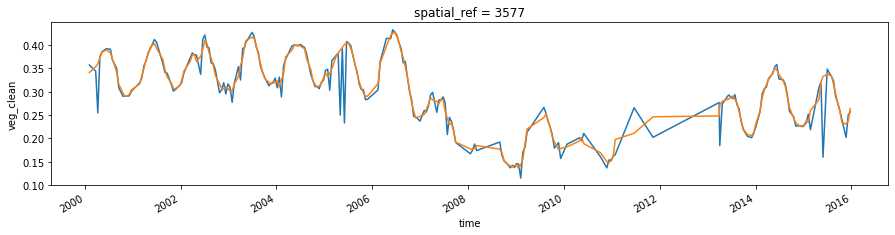

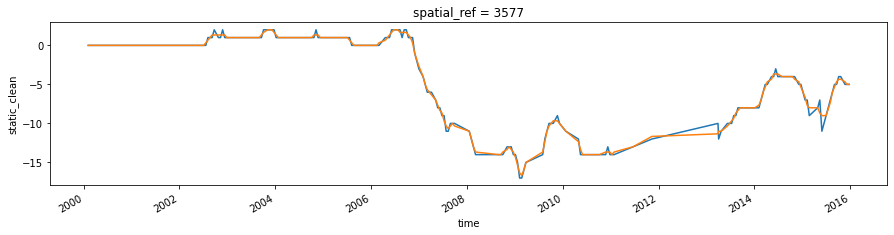

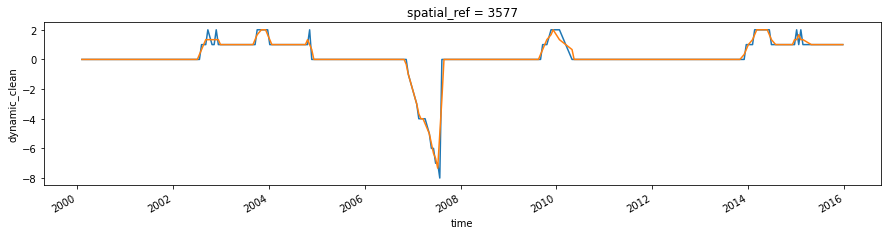

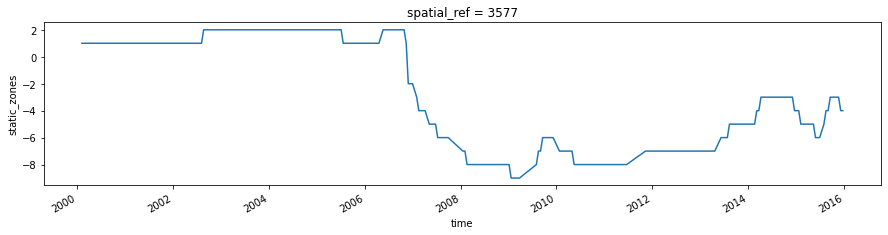

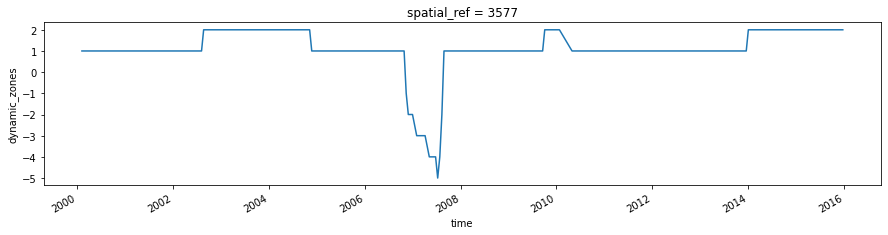

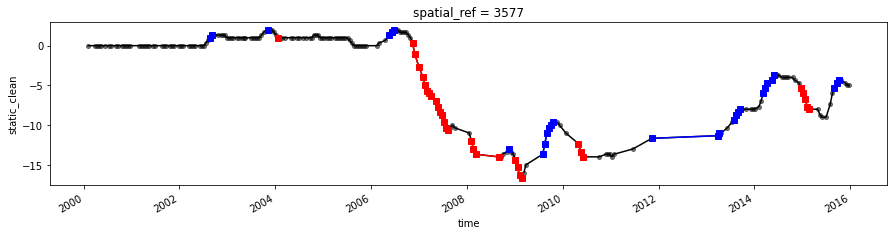

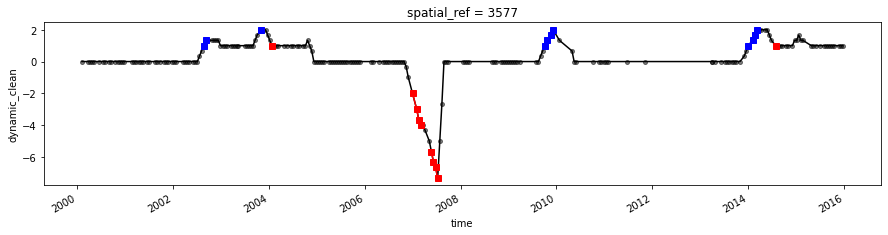

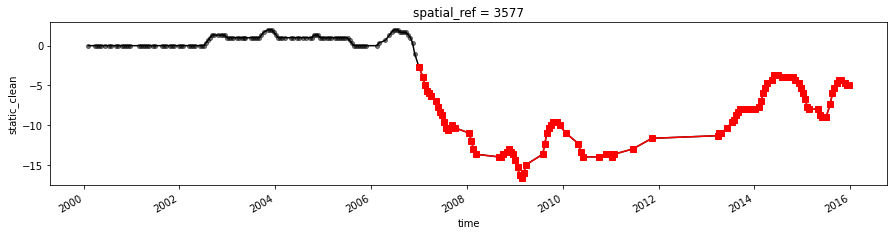

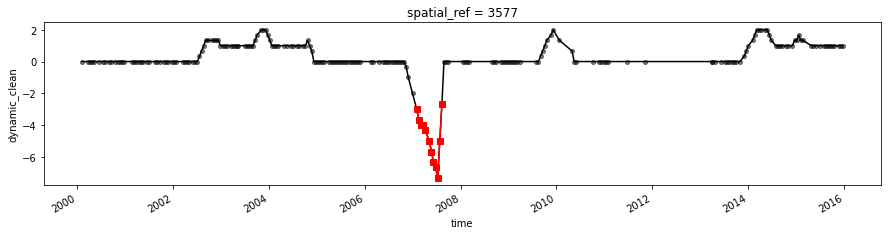

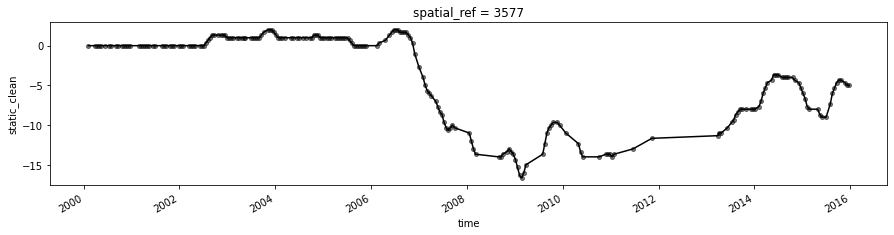

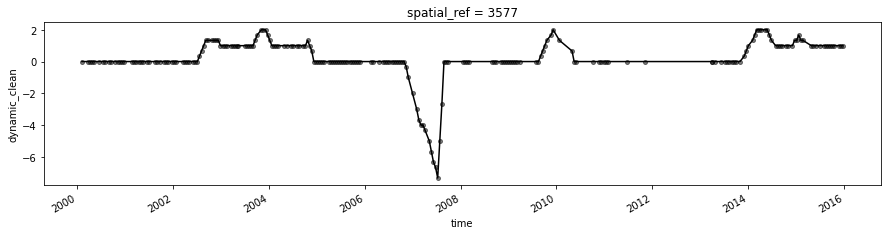

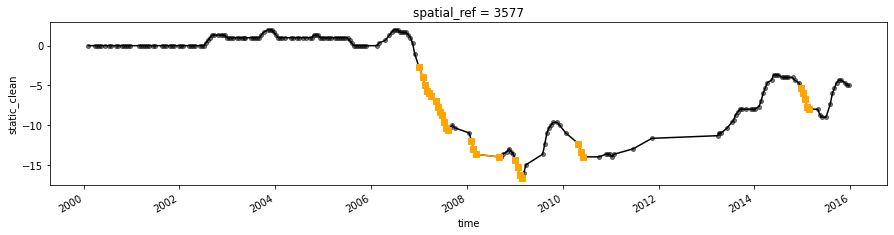

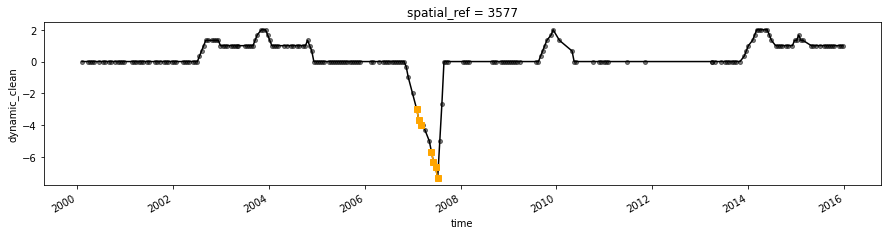

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

if True:
    fig = plt.figure(figsize=[15, 3])
    ds_tmp['veg_idx'].plot()
    ds_tmp['veg_clean'].plot()
    plt.show()

    fig = plt.figure(figsize=[15, 3])
    ds_tmp['static_raw'].plot()
    ds_tmp['static_clean'].plot()
    plt.show()

    fig = plt.figure(figsize=[15, 3])
    ds_tmp['dynamic_raw'].plot()
    ds_tmp['dynamic_clean'].plot()
    plt.show()

    fig = plt.figure(figsize=[15, 3])
    ds_tmp['static_zones'].plot()
    plt.show()

    fig = plt.figure(figsize=[15, 3])
    ds_tmp['dynamic_zones'].plot()
    plt.show()    
    
    fig = plt.figure(figsize=[15, 3])
    ds_tmp['static_clean'].plot(color='black')
    ds_tmp['static_clean'].plot(linestyle='None', markersize=4, marker='o', color='black', alpha=0.5)
    ds_tmp['static_clean'].where(ds_tmp['static_rule_one'] > 0).plot(marker='s', color='blue')
    ds_tmp['static_clean'].where(ds_tmp['static_rule_one'] < 0).plot(marker='s', color='red')
    plt.show()

    fig = plt.figure(figsize=[15, 3])
    ds_tmp['dynamic_clean'].plot(color='black')
    ds_tmp['dynamic_clean'].plot(linestyle='None', markersize=4, marker='o', color='black', alpha=0.5)
    ds_tmp['dynamic_clean'].where(ds_tmp['dynamic_rule_one'] > 0).plot(marker='s', color='blue')
    ds_tmp['dynamic_clean'].where(ds_tmp['dynamic_rule_one'] < 0).plot(marker='s', color='red')
    plt.show()
    
    fig = plt.figure(figsize=[15, 3])
    ds_tmp['static_clean'].plot(color='black')
    ds_tmp['static_clean'].plot(linestyle='None', markersize=4, marker='o', color='black', alpha=0.5)
    ds_tmp['static_clean'].where(ds_tmp['static_rule_two'] > 0).plot(marker='s', color='blue')
    ds_tmp['static_clean'].where(ds_tmp['static_rule_two'] < 0).plot(marker='s', color='red')
    plt.show()

    fig = plt.figure(figsize=[15, 3])
    ds_tmp['dynamic_clean'].plot(color='black')
    ds_tmp['dynamic_clean'].plot(linestyle='None', markersize=4, marker='o', color='black', alpha=0.5)
    ds_tmp['dynamic_clean'].where(ds_tmp['dynamic_rule_two'] > 0).plot(marker='s', color='blue')
    ds_tmp['dynamic_clean'].where(ds_tmp['dynamic_rule_two'] < 0).plot(marker='s', color='red')
    plt.show()
    
    fig = plt.figure(figsize=[15, 3])
    ds_tmp['static_clean'].plot(color='black')
    ds_tmp['static_clean'].plot(linestyle='None', markersize=4, marker='o', color='black', alpha=0.5)
    ds_tmp['static_clean'].where(ds_tmp['static_rule_three'] > 0).plot(marker='s', color='blue')
    ds_tmp['static_clean'].where(ds_tmp['static_rule_three'] < 0).plot(marker='s', color='red')
    plt.show()

    fig = plt.figure(figsize=[15, 3])
    ds_tmp['dynamic_clean'].plot(color='black')
    ds_tmp['dynamic_clean'].plot(linestyle='None', markersize=4, marker='o', color='black', alpha=0.5)
    ds_tmp['dynamic_clean'].where(ds_tmp['dynamic_rule_three'] > 0).plot(marker='s', color='blue')
    ds_tmp['dynamic_clean'].where(ds_tmp['dynamic_rule_three'] < 0).plot(marker='s', color='red')
    plt.show()
    
    fig = plt.figure(figsize=[15, 3])
    ds_tmp['static_clean'].plot(color='black')
    ds_tmp['static_clean'].plot(linestyle='None', markersize=4, marker='o', color='black', alpha=0.5)
    ds_tmp['static_clean'].where(ds_tmp['static_alerts'] > 0).plot(marker='s', color='orange')
    plt.show()
    
    fig = plt.figure(figsize=[15, 3])
    ds_tmp['dynamic_clean'].plot(color='black')
    ds_tmp['dynamic_clean'].plot(linestyle='None', markersize=4, marker='o', color='black', alpha=0.5)
    ds_tmp['dynamic_clean'].where(ds_tmp['dynamic_alerts'] > 0).plot(marker='s', color='orange')
    plt.show()